In [2]:
# IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU

# **CONFIG BLOCK**

In [3]:
DATA_DIR = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image"  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_TRAIN = 0.7
SPLIT_VAL = 0.15
SPLIT_TEST = 0.15


# **DATA PREPROCESSING, MODEL BUILDING AND TRAINING (Activation Function: LeakyReLU)**


In [4]:
# DATA PREPROCESSING 
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=SPLIT_VAL + SPLIT_TEST
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# split validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_TEST / (SPLIT_VAL + SPLIT_TEST))

val_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# BUILD VGG16 FROM SCRATCH (using LeakyReLU activations)
model = Sequential([

    Conv2D(64, (3,3), padding='same', input_shape=(*IMG_SIZE, 3)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(128, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(128, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), strides=(2,2)),


    Conv2D(256, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(256, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(256, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(512, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(512, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(512, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), strides=(2,2)),


    Conv2D(512, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(512, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    Conv2D(512, (3,3), padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), strides=(2,2)),

    Flatten(),
    Dense(4096),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(4096),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(train_gen.num_classes, activation='softmax')
])

# COMPILE 
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# TRAIN 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Found 2433 images belonging to 3 classes.
Found 1738 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1763556520.925881      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multipr

Epoch 1/20


I0000 00:00:1763556527.328357     128 service.cc:148] XLA service 0x7fdff4001ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763556527.329130     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763556527.957848     128 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763556548.597022     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4408 - loss: 1.0023

77/77 ━━━━━━━━━━━━━━━━━━━━ 62s 470ms/step - accuracy: 0.4426 - loss: 1.0001 - val_accuracy: 0.6766 - val_loss: 0.7181
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7650 - loss: 0.5521

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 367ms/step - accuracy: 0.7653 - loss: 0.5518 - val_accuracy: 0.8504 - val_loss: 0.3989
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.8312 - loss: 0.4356 - val_accuracy: 0.8205 - val_loss: 0.4423
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8249 - loss: 0.4382

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 366ms/step - accuracy: 0.8249 - loss: 0.4380 - val_accuracy: 0.8544 - val_loss: 0.3658
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 296ms/step - accuracy: 0.8046 - loss: 0.4893 - val_accuracy: 0.8539 - val_loss: 0.3480
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.8641 - loss: 0.3503 - val_accuracy: 0.8147 - val_loss: 0.4577
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8524 - loss: 0.3583

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.8526 - loss: 0.3579 - val_accuracy: 0.8924 - val_loss: 0.2670
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8878 - loss: 0.2765

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.8877 - loss: 0.2767 - val_accuracy: 0.9091 - val_loss: 0.2559
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 295ms/step - accuracy: 0.8964 - loss: 0.2487 - val_accuracy: 0.9022 - val_loss: 0.2375
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8998 - loss: 0.2381

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.8998 - loss: 0.2381 - val_accuracy: 0.9304 - val_loss: 0.1909
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9190 - loss: 0.2157 - val_accuracy: 0.9045 - val_loss: 0.2373
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9223 - loss: 0.1902

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 366ms/step - accuracy: 0.9223 - loss: 0.1903 - val_accuracy: 0.9315 - val_loss: 0.1781
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9191 - loss: 0.1934

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.9192 - loss: 0.1931 - val_accuracy: 0.9499 - val_loss: 0.1265
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9461 - loss: 0.1388

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 366ms/step - accuracy: 0.9461 - loss: 0.1388 - val_accuracy: 0.9609 - val_loss: 0.1080
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9534 - loss: 0.1368 - val_accuracy: 0.9517 - val_loss: 0.1162
Epoch 16/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9612 - loss: 0.1064 - val_accuracy: 0.9223 - val_loss: 0.1640
Epoch 17/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9607 - loss: 0.1016

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 366ms/step - accuracy: 0.9606 - loss: 0.1017 - val_accuracy: 0.9793 - val_loss: 0.0722
Epoch 18/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9658 - loss: 0.0819 - val_accuracy: 0.9655 - val_loss: 0.0925
Epoch 19/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 296ms/step - accuracy: 0.9618 - loss: 0.0952 - val_accuracy: 0.9753 - val_loss: 0.0717
Epoch 20/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9797 - loss: 0.0660 - val_accuracy: 0.9632 - val_loss: 0.0895



# **EVALUATION AND METRICS**


55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9031 - loss: 0.3238

 Test Accuracy: 92.75%
 Test Loss: 0.2465
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step

========== Classification Report ==========
                 precision    recall  f1-score   support

   Lung_Opacity     0.8752    0.9235    0.8987       562
         Normal     0.9341    0.8848    0.9088       625
Viral Pneumonia     0.9764    0.9800    0.9782       550

       accuracy                         0.9275      1737
      macro avg     0.9286    0.9294    0.9286      1737
   weighted avg     0.9285    0.9275    0.9275      1737



<Figure size 800x600 with 0 Axes>

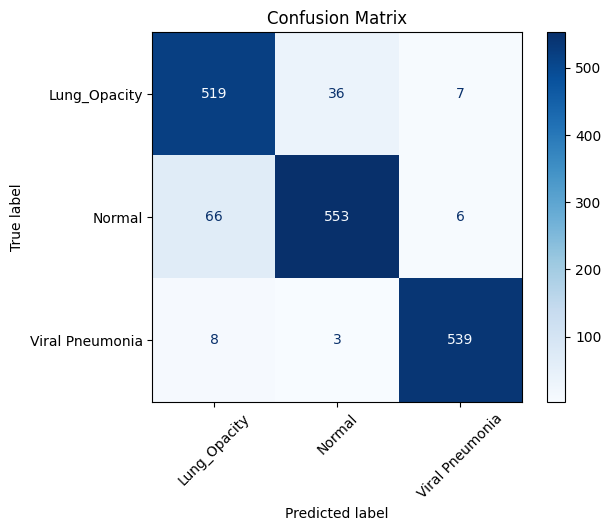

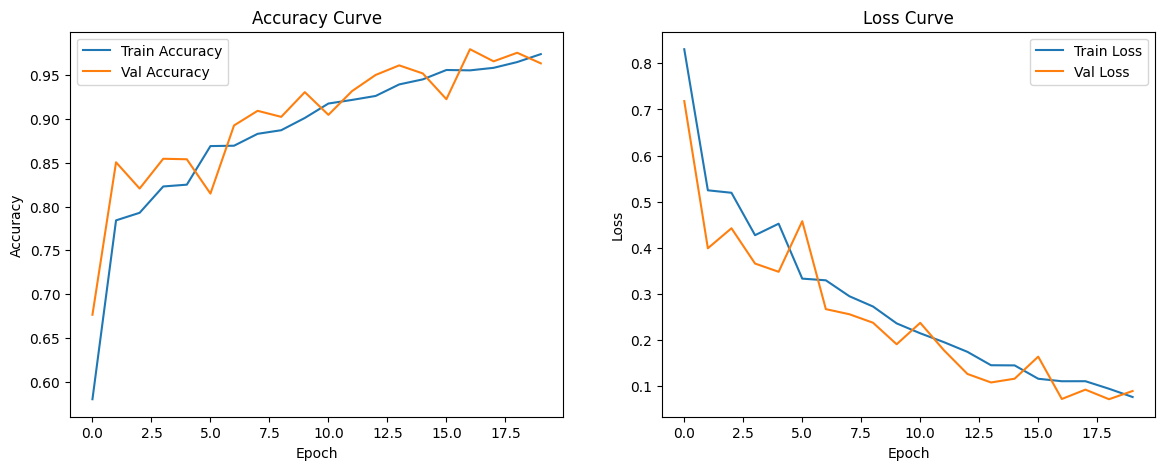

In [5]:
#  EVALUATE 
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# METRICS: CONFUSION MATRIX, PRECISION, RECALL, F1 Score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
Y_true = test_gen.classes
Y_pred_probs = model.predict(test_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Labels (class names)
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n========== Classification Report ==========")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()


#  PLOTS 
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **CONFIG BLOCK**

In [6]:
DATA_DIR = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image"  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_TRAIN = 0.7
SPLIT_VAL = 0.15
SPLIT_TEST = 0.15


# **DATA PREPROCESSING, MODEL BUILDING AND TRAINING (Activation Function: tanh)**


In [7]:
# DATA PREPROCESSING 
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=SPLIT_VAL + SPLIT_TEST
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# split validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_TEST / (SPLIT_VAL + SPLIT_TEST))

val_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# BUILD VGG16 FROM SCRATCH (using tanh activations)
model = Sequential([

    Conv2D(64, (3,3), activation='tanh', padding='same', input_shape=(*IMG_SIZE, 3)),
    Conv2D(64, (3,3), activation='tanh', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(128, (3,3), activation='tanh', padding='same'),
    Conv2D(128, (3,3), activation='tanh', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(256, (3,3), activation='tanh', padding='same'),
    Conv2D(256, (3,3), activation='tanh', padding='same'),
    Conv2D(256, (3,3), activation='tanh', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(512, (3,3), activation='tanh', padding='same'),
    Conv2D(512, (3,3), activation='tanh', padding='same'),
    Conv2D(512, (3,3), activation='tanh', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(512, (3,3), activation='tanh', padding='same'),
    Conv2D(512, (3,3), activation='tanh', padding='same'),
    Conv2D(512, (3,3), activation='tanh', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    Flatten(),
    Dense(4096, activation='tanh'),
    Dropout(0.5),
    Dense(4096, activation='tanh'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

# COMPILE 
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# TRAIN 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Found 2433 images belonging to 3 classes.
Found 1738 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6054 - loss: 1.3782

77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 439ms/step - accuracy: 0.6067 - loss: 1.3713 - val_accuracy: 0.8165 - val_loss: 0.4692
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - accuracy: 0.8137 - loss: 0.4625 - val_accuracy: 0.7975 - val_loss: 0.4533
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8206 - loss: 0.4364

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 367ms/step - accuracy: 0.8208 - loss: 0.4360 - val_accuracy: 0.8412 - val_loss: 0.3593
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.8702 - loss: 0.3373 - val_accuracy: 0.8222 - val_loss: 0.3908
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8491 - loss: 0.3930

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 360ms/step - accuracy: 0.8490 - loss: 0.3935 - val_accuracy: 0.8642 - val_loss: 0.3537
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8715 - loss: 0.3199

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 355ms/step - accuracy: 0.8716 - loss: 0.3197 - val_accuracy: 0.9298 - val_loss: 0.1988
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9073 - loss: 0.2397

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 358ms/step - accuracy: 0.9073 - loss: 0.2397 - val_accuracy: 0.9338 - val_loss: 0.1637
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9293 - loss: 0.1700

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.9291 - loss: 0.1705 - val_accuracy: 0.9511 - val_loss: 0.1485
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9412 - loss: 0.1628

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 359ms/step - accuracy: 0.9411 - loss: 0.1629 - val_accuracy: 0.9816 - val_loss: 0.0744
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9689 - loss: 0.1002 - val_accuracy: 0.9707 - val_loss: 0.0758
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9767 - loss: 0.0581 - val_accuracy: 0.9626 - val_loss: 0.0962
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9706 - loss: 0.0786 - val_accuracy: 0.9747 - val_loss: 0.0906



# **EVALUATION AND METRICS**


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8962 - loss: 0.2837

 Test Accuracy: 92.98%
 Test Loss: 0.1898
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step

========== Classification Report ==========
                 precision    recall  f1-score   support

   Lung_Opacity     0.9079    0.8950    0.9014       562
         Normal     0.8998    0.9200    0.9098       625
Viral Pneumonia     0.9871    0.9764    0.9817       550

       accuracy                         0.9298      1737
      macro avg     0.9316    0.9305    0.9310      1737
   weighted avg     0.9301    0.9298    0.9299      1737



<Figure size 800x600 with 0 Axes>

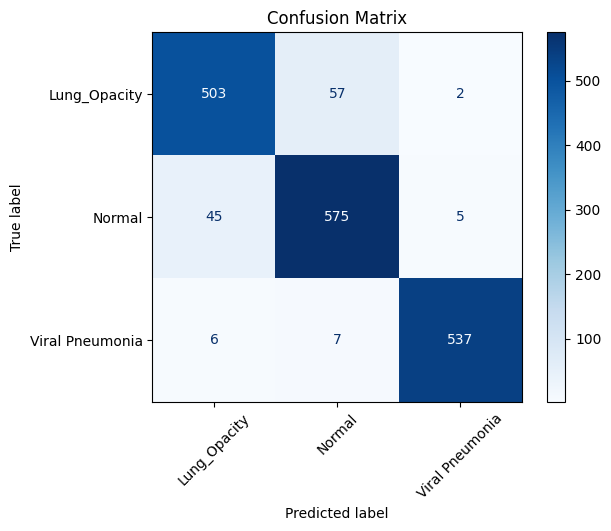

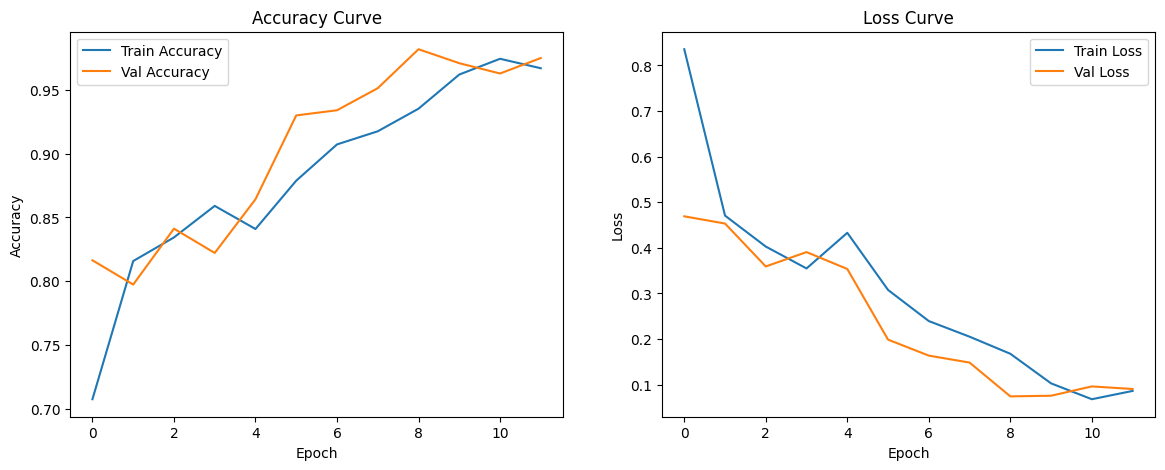

In [8]:
#  EVALUATE 
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# METRICS: CONFUSION MATRIX, PRECISION, RECALL, F1 Score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
Y_true = test_gen.classes
Y_pred_probs = model.predict(test_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Labels (class names)
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n========== Classification Report ==========")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()


#  PLOTS 
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
